# Bron¶
http://www.femto-st.fr/en/Research-departments/AS2M/Research-groups/PHM/IEEE-PHM-2012-Data-challenge.php

## Setup
Datasets opgenomen onder 3 verschillende condities.

Regarding the PHM challenge, data representing 3 dierent loads were considered:

- First operating conditions: 1800 rpm and 4000 N;
- Second operating conditions: 1650 rpm and 4200 N;
- Third operating conditions: 1500 rpm and 5000 N.

```
Cond1      Cond2      Cond3
Learning set  
Bearing1_1 Bearing2_1 Bearing3_1  
Bearing1_2 Bearing2_2 Bearing3_2  

Test set 
Bearing1_3 Bearing2_3 Bearing3_3  
Bearing1_4 Bearing2_4  
Bearing1_5 Bearing2_5  
Bearing1_6 Bearing2_6
Bearing1_7 Bearing2_7  
```

## Organization of data
* files: acc_xxxxx.csv, and temp_xxxxx.csv
* Vibration signals (horizontal and vertical)
    - Sampling frequency: 25.6 kHz
    - Recordings: 2560 samples (i.e. 1/10 s) are recorded each 10 seconds (see Fig. 6)
* Temperature signals
    - Sampling frequency: 10 Hz
    - Recordings: 600 samples are recorded each minute
    
File inhoud:
```
Column         1     2      3     4            5            6
Vibr. signal Hour Minute Second mu-second Horiz. accel. vert. accel.
Temp. signal Hour Minute Second 0.x second Rtd sensor        -
```


## init cells

In [123]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from glob import glob
from keras import regularizers
from keras import backend
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model, Sequential, load_model
import datetime

In [28]:
fs = 25600
nrSamples = fs / 10

train_folder = '/Users/etto/Desktop/tpDatasets/FEMTOBearingDataSet/Learning_set/'
test_folder = '/Users/etto/Desktop/tpDatasets/FEMTOBearingDataSet/Test_set/Test_set/'
train_bearings = ['bearing1_{:d}'.format(i) for i in range(1,3)]
test_bearings = ['bearing1_{:d}'.format(i) for i in range(3,8)]

train_folders = ['{:s}{:s}/'.format(train_folder, bearing) for bearing in train_bearings]
test_folders = ['{:s}{:s}/'.format(test_folder, bearing) for bearing in test_bearings]

column_names = ['hour', 'minute','second','micsec','horAcc','vertAcc']

## lees signalen en sla op (horizontaal)

In [29]:
def constructSignal(bearing_folder, axis='horAcc'):
    signal = []
    fileformat = 'acc_{:05d}.csv'
    nrFiles = len(glob(bearing_folder + 'acc*csv'))
    print(bearing_folder)
    for nr in range(1, nrFiles+1):
        filename = bearing_folder + fileformat.format(nr)
        values = pd.read_csv(filename,names=column_names)[axis]
        signal = np.append(signal, np.array(values))
    return signal

## Vervolgstappen
* maak spectrogram van train bestanden
* combineer eerste twee bestanden met elkaar (bearing 1_1 en 1_2)
* voer autoencoder uit voor combinatie van 1_1 en 1_2
* bepaal de RUL voor elk tijdstip
* zet beide bestanden om naar encoded representatie en voeg RUL daaraan toe
* train op RUL
* per testbestand: (1_3 t/m 1_7): maak representatie en bepaal per bestand (op basis van document)
* plot voorspelde RULs en daadwerkelijke RULS in 1 grafiek

### combineer eerste twee bestanden met elkaar (bearing 1_1 en 1_2)

In [43]:
def getSpectro(signal):
    freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=25600, nperseg=2560,noverlap=0)
    return spectrogram.T

In [1]:
%store -r signal_1_1_hor
%store -r signal_1_2_hor
spectrograms_train = [getSpectro(signal_1_1_hor), getSpectro(signal_1_2_hor)]
print(np.shape(spectrograms_train[0]))
print(np.shape(spectrograms_train[1]))

allSpectros = np.append(spectrograms_train[0], spectrograms_train[1], axis=0)
print(np.shape(allSpectros))

NameError: name 'getSpectro' is not defined

### voer autoencoder uit voor combinatie van 1_1 en 1_2

In [48]:
# maak train en test data
def splitTestAndTrain(np_spec, test_frac=0.1):
    # test_frac = 0.1  # test data ratio for autoencoder
    nr_auto_encode = int(test_frac * len(np_spec))
    idx_all = range(len(np_spec))
    idx_test = np.random.choice(idx_all, size=nr_auto_encode,replace=False)

    x_test = np_spec[idx_test]
    x_train = np_spec[np.delete(idx_all,idx_test,0)]

    # normalize values
    norm_vec = np.linalg.norm(np_spec, axis=0)
    x_train = x_train / norm_vec
    x_test = x_test / norm_vec
    
    return x_train, x_test

In [49]:
x_train, x_test = splitTestAndTrain(allSpectros)
print(np.shape(x_train))
print(np.shape(x_test))

(3307, 1281)
(367, 1281)


Train on 3307 samples, validate on 367 samples
Epoch 1/20
3307/3307 [==============================] - 1s 380us/step - loss: 0.6821 - val_loss: 0.6689
Epoch 2/20
3307/3307 [==============================] - 1s 291us/step - loss: 0.6431 - val_loss: 0.5976
Epoch 3/20
3307/3307 [==============================] - 1s 294us/step - loss: 0.4801 - val_loss: 0.3208
Epoch 4/20
3307/3307 [==============================] - 1s 287us/step - loss: 0.1965 - val_loss: 0.1105
Epoch 5/20
3307/3307 [==============================] - 1s 296us/step - loss: 0.0799 - val_loss: 0.0579
Epoch 6/20
3307/3307 [==============================] - 1s 289us/step - loss: 0.0498 - val_loss: 0.0416
Epoch 7/20
3307/3307 [==============================] - 1s 291us/step - loss: 0.0392 - val_loss: 0.0348
Epoch 8/20
3307/3307 [==============================] - 1s 302us/step - loss: 0.0343 - val_loss: 0.0314
Epoch 9/20
3307/3307 [==============================] - 1s 301us/step - loss: 0.0317 - val_loss: 0.0295
Epoch 10/20
3307/

Text(0.5,1,'validation loss')

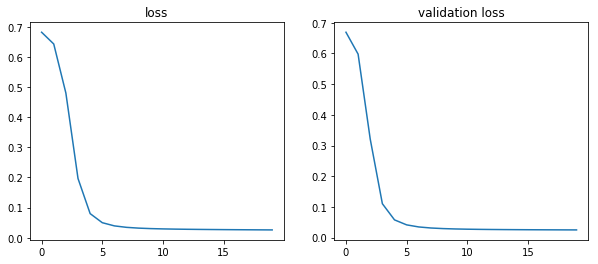

In [54]:
input_dim = len(allSpectros[0])
encoding_dim = 100

np_spec = allSpectros

inp = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inp)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inp, decoded)

# separate encoder model
encoder = Model(inp, encoded)

# decoder model
# create a placeholder for an encoded input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train autoencoder
dateStr = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
autoencoder.fit(x_train, x_train, 
                epochs=20, # lijkt wel genoeg te zijn
                shuffle=True,validation_data=(x_test,x_test))

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(autoencoder.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(autoencoder.history.history['val_loss'])
ax2.set_title('validation loss')

In [55]:
modelpath = 'models/'
autoencoder.save(modelpath + 'autoencoder.h5')
encoder.save(modelpath + 'encoder.h5')
decoder.save(modelpath + 'decoder.h5')

### bepaal de RUL voor elk tijdstip
tussenpauze per bestand is 10 sec  
RUL is dus (#bestanden - bestandsnr) * 10 seconden

### zet beide bestanden om naar encoded representatie en bepaal RUL vector

In [98]:
encoded_train = encoder.predict(allSpectros)

nr_samples = len(spectrograms_train[0])
train_Y_values1 = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])

nr_samples = len(spectrograms_train[1])
train_Y_values2 = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])

train_Y_values = np.append(train_Y_values1, train_Y_values2)
print(np.shape(train_Y_values))
print(np.shape(encoded_train))

(3674,)
(3674, 100)


### train op RUL

In [108]:
input_dim = np.shape(encoded_train)[1]

rulModel = Sequential()
rulModel.add(Dense(25, input_dim=input_dim, activation='relu',name='layer1'))
#rulModel.add(Dense(12, activation='relu', name='layer2'))
#rulModel.add(Dense(25, activation='relu',name='layer3'))
rulModel.add(Dense(1, activation='linear', name='output_layer'))
rulModel.compile(loss='mean_squared_error', optimizer='adam')
history = rulModel.fit(encoded_train, train_Y_values, epochs=150,shuffle=True, verbose=1)

Epoch 1/150
3674/3674 [==============================] - 1s 172us/step - loss: 205113070.1796
Epoch 2/150
3674/3674 [==============================] - 0s 53us/step - loss: 203307891.3533
Epoch 3/150
3674/3674 [==============================] - 0s 52us/step - loss: 200204939.7409
Epoch 4/150
3674/3674 [==============================] - 0s 54us/step - loss: 195809412.2069
Epoch 5/150
3674/3674 [==============================] - 0s 53us/step - loss: 190240601.5895
Epoch 6/150
3674/3674 [==============================] - 0s 55us/step - loss: 183673722.0076
Epoch 7/150
3674/3674 [==============================] - 0s 53us/step - loss: 176300067.5972
Epoch 8/150
3674/3674 [==============================] - 0s 54us/step - loss: 168316635.4796
Epoch 9/150
3674/3674 [==============================] - 0s 62us/step - loss: 159890603.5754
Epoch 10/150
3674/3674 [==============================] - 0s 53us/step - loss: 151239246.3625
Epoch 11/150
3674/3674 [==============================] - 0s 55us/st

3674/3674 [==============================] - 0s 56us/step - loss: 68329817.7594
Epoch 90/150
3674/3674 [==============================] - 0s 58us/step - loss: 68326340.1219
Epoch 91/150
3674/3674 [==============================] - 0s 60us/step - loss: 68340334.8416
Epoch 92/150
3674/3674 [==============================] - 0s 60us/step - loss: 68328534.2341
Epoch 93/150
3674/3674 [==============================] - 0s 56us/step - loss: 68326830.2275
Epoch 94/150
3674/3674 [==============================] - 0s 60us/step - loss: 68324536.1829
Epoch 95/150
3674/3674 [==============================] - 0s 91us/step - loss: 68326222.5411
Epoch 96/150
3674/3674 [==============================] - 0s 59us/step - loss: 68325939.7779
Epoch 97/150
3674/3674 [==============================] - 0s 57us/step - loss: 68329905.7529
Epoch 98/150
3674/3674 [==============================] - 0s 67us/step - loss: 68322262.0250
Epoch 99/150
3674/3674 [==============================] - 0s 55us/step - loss: 6832

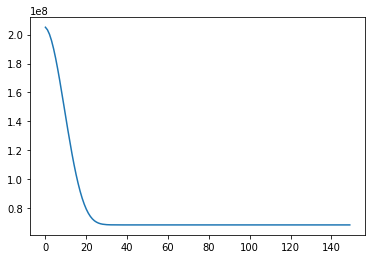

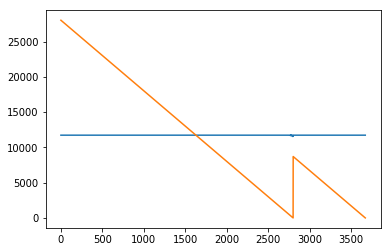

In [109]:
plt.plot(history.history['loss'])
plt.show()

plt.figure()
predictions = rulModel.predict(encoded_train)
plt.plot(predictions)
plt.plot(train_Y_values)
plt.show()

resultaat niet geweldig...
niet direct verbetering met meer of minder lagen...

### nieuwe aanpak: zonder autoencoder, en dan eens wat meer experimenteren met meer of minder lagen

In [110]:
X = allSpectros
Y = train_Y_values

In [117]:
input_dim = np.shape(X)[1]

rulModel = Sequential()
rulModel.add(Dense(300, input_dim=input_dim, activation='relu',name='layer1'))
rulModel.add(Dense(150, activation='relu', name='layer2'))
rulModel.add(Dense(25, activation='relu',name='layer3'))
rulModel.add(Dense(1, activation='linear', name='output_layer'))
rulModel.compile(loss='mean_squared_error', optimizer='adam')
history = rulModel.fit(X, Y, epochs=500,shuffle=True, verbose=1)

Epoch 1/500
3674/3674 [==============================] - 2s 500us/step - loss: 204058435.7714
Epoch 2/500
3674/3674 [==============================] - 1s 320us/step - loss: 155380804.8013
Epoch 3/500
3674/3674 [==============================] - 1s 336us/step - loss: 75501344.2918
Epoch 4/500
3674/3674 [==============================] - 1s 328us/step - loss: 68217733.6527
Epoch 5/500
3674/3674 [==============================] - 1s 360us/step - loss: 66102229.8487
Epoch 6/500
3674/3674 [==============================] - 2s 422us/step - loss: 64596644.1394
Epoch 7/500
3674/3674 [==============================] - 1s 298us/step - loss: 63240650.2319
Epoch 8/500
3674/3674 [==============================] - 1s 289us/step - loss: 62030897.4154
Epoch 9/500
3674/3674 [==============================] - 1s 353us/step - loss: 60800772.7643
Epoch 10/500
3674/3674 [==============================] - 1s 320us/step - loss: 59501618.9461
Epoch 11/500
3674/3674 [==============================] - 1s 269us/

3674/3674 [==============================] - 1s 308us/step - loss: 2393719.9773
Epoch 176/500
3674/3674 [==============================] - 1s 305us/step - loss: 2365773.4867
Epoch 177/500
3674/3674 [==============================] - 1s 327us/step - loss: 2333008.3329
Epoch 178/500
3674/3674 [==============================] - 1s 390us/step - loss: 2304625.0076
Epoch 179/500
3674/3674 [==============================] - 1s 373us/step - loss: 2287579.6705
Epoch 180/500
3674/3674 [==============================] - 1s 398us/step - loss: 2253778.7518
Epoch 181/500
3674/3674 [==============================] - 1s 353us/step - loss: 2205012.5920
Epoch 182/500
3674/3674 [==============================] - 1s 346us/step - loss: 2152079.5250
Epoch 183/500
3674/3674 [==============================] - 1s 348us/step - loss: 2167533.9430
Epoch 184/500
3674/3674 [==============================] - 1s 332us/step - loss: 2125275.9743
Epoch 185/500
3674/3674 [==============================] - 1s 354us/step -

3674/3674 [==============================] - 2s 450us/step - loss: 903295.0366
Epoch 350/500
3674/3674 [==============================] - 2s 415us/step - loss: 911038.1352
Epoch 351/500
3674/3674 [==============================] - 1s 397us/step - loss: 912643.0042
Epoch 352/500
3674/3674 [==============================] - 2s 472us/step - loss: 927102.2569
Epoch 353/500
3674/3674 [==============================] - 1s 387us/step - loss: 900332.2443
Epoch 354/500
3674/3674 [==============================] - 1s 323us/step - loss: 898105.7753
Epoch 355/500
3674/3674 [==============================] - 1s 363us/step - loss: 920145.2519
Epoch 356/500
3674/3674 [==============================] - 1s 396us/step - loss: 904594.6460
Epoch 357/500
3674/3674 [==============================] - 1s 368us/step - loss: 939762.7342
Epoch 358/500
3674/3674 [==============================] - 2s 430us/step - loss: 899182.6649
Epoch 359/500
3674/3674 [==============================] - 2s 436us/step - loss: 873

In [119]:
rulModel.save('models/rulModel_300_150_25_1_ep500.h5')

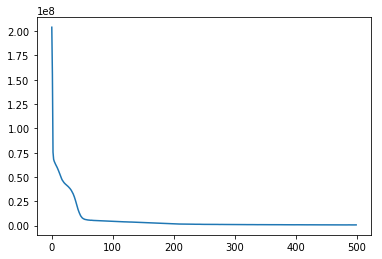

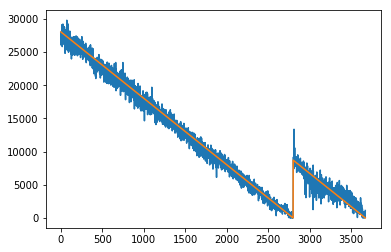

In [118]:
plt.plot(history.history['loss'])
plt.show()

plt.figure()
predictions = rulModel.predict(X)
plt.plot(predictions)
plt.plot(Y)
plt.show()

In [120]:
input_dim = np.shape(X)[1]

rulModel = Sequential()
rulModel.add(Dense(300, input_dim=input_dim, activation='relu',name='layer1'))
rulModel.add(Dense(150, activation='relu', name='layer2'))
rulModel.add(Dense(25, activation='relu',name='layer3'))
rulModel.add(Dense(1, activation='linear', name='output_layer'))
rulModel.compile(loss='mean_squared_error', optimizer='adam')
history = rulModel.fit(X, Y, epochs=100,shuffle=True, verbose=1)
rulModel.save('models/rulModel_300_150_25_1_ep100.h5')

Epoch 1/100
3674/3674 [==============================] - 2s 552us/step - loss: 205089244.3244
Epoch 2/100
3674/3674 [==============================] - 1s 353us/step - loss: 185044610.0381
Epoch 3/100
3674/3674 [==============================] - 1s 373us/step - loss: 107557524.2722
Epoch 4/100
3674/3674 [==============================] - 1s 344us/step - loss: 71158990.0142
Epoch 5/100
3674/3674 [==============================] - 1s 374us/step - loss: 68217752.7403
Epoch 6/100
3674/3674 [==============================] - 1s 366us/step - loss: 66315969.3108
Epoch 7/100
3674/3674 [==============================] - 1s 354us/step - loss: 64854261.2085
Epoch 8/100
3674/3674 [==============================] - 1s 348us/step - loss: 63457919.3489
Epoch 9/100
3674/3674 [==============================] - 1s 379us/step - loss: 62197054.8547
Epoch 10/100
3674/3674 [==============================] - 1s 395us/step - loss: 60841760.0915
Epoch 11/100
3674/3674 [==============================] - 1s 376us

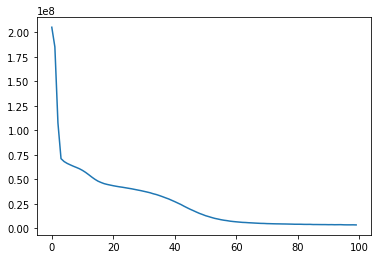

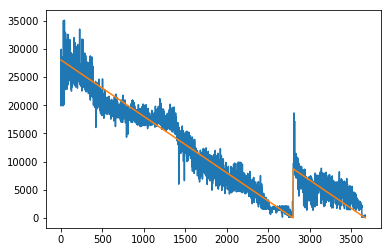

In [121]:
plt.plot(history.history['loss'])
plt.show()

plt.figure()
predictions = rulModel.predict(X)
plt.plot(predictions)
plt.plot(Y)
plt.show()

### volgende stap: voorspellen van RUL van andere bearings

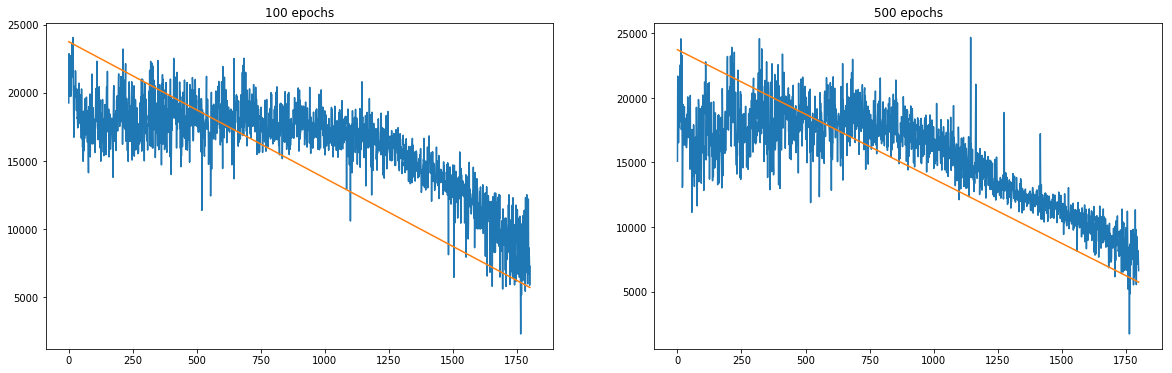

In [141]:
#1_3: RUL = 5730
RUL_1_3 = 5730
%store -r signal_1_3_hor
spectro_1_3 = getSpectro(signal_1_3_hor)

# True Y values
nr_samples = len(spectro_1_3)
Y_values = np.array([10 * (nr_samples - i) + RUL_1_3 for i in range(1, nr_samples +1)])

modelA = load_model('models/rulModel_300_150_25_1_ep100.h5') # type: Model
modelB = load_model('models/rulModel_300_150_25_1_ep500.h5') # type: Model

predictionsA = modelA.predict(spectro_1_3)
predictionsB = modelB.predict(spectro_1_3)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
plt.plot(predictionsA)
plt.plot(Y_values)
ax1.set_title('100 epochs')

ax2 = fig.add_subplot(1,2,2)
plt.plot(predictionsB)
plt.plot(Y_values)
ax2.set_title('500 epochs')
plt.show()

### kladwerk om evaluate te duiden

In [144]:
res = modelA.evaluate(spectro_1_3, Y_values)
print(res/nr_samples)

1802/1802 [==============================] - 0s 111us/step
7704.033850044531


In [168]:
res = modelB.evaluate(spectro_1_3, Y_values)
print(res/nr_samples)

1802/1802 [==============================] - 0s 159us/step
5682.540143766761
10239937.339067703


In [175]:
predictionsA = modelA.predict(spectro_1_3)
predictionsA = np.array([val[0] for val in predictionsA])
diff = predictionsA - Y_values
print(len(diff))
d2 = np.square(diff)
sm = np.sum(d2)
print(sm/1802)

1802
13882668.974996068


In [167]:
print(np.sqrt(sm))

158166.27166669548


In [169]:
res = modelB.evaluate(X,Y)

3674/3674 [==============================] - 1s 204us/step


In [170]:
print(res)

716537.6923695223


In [171]:
print(np.sqrt(68322542.6413))

8265.74513527365


In [172]:
print(68322542.6413/3674)

18596.228263826888


In [177]:
predictionsTr = modelB.predict(X)
predictionsTr = np.array([val[0] for val in predictionsTr])
diff = predictionsTr - Y
print(len(diff))
d2 = np.square(diff)
sm = np.sum(d2)
print(np.sqrt(sm/3674))

3674
846.4854955783145


In [187]:
#loss model A
res = modelA.evaluate(spectro_1_3, Y_values)
print(res)

predictionsA = modelA.predict(spectro_1_3)
predictionsA = np.array([val[0] for val in predictionsA])
diff = predictionsA - Y_values
print(len(diff))
d2 = np.square(diff)
sm = np.sum(d2)
print(sm/len(predictionsA))

print(np.sqrt(res))

1802/1802 [==============================] - 0s 113us/step
13882668.997780245
1802
13882668.974996068
3725.9453830914167


#### evaluate is dus de mean square error

### grafiek en evaluatie in functie

In [196]:
def evaluate_signal(signal, RUL_value):
    spectro = getSpectro(signal)

    # True Y values
    nr_samples = len(spectro)
    Y_values = np.array([10 * (nr_samples - i) + RUL_value for i in range(1, nr_samples +1)])

    modelA = load_model('models/rulModel_300_150_25_1_ep100.h5') # type: Model
    modelB = load_model('models/rulModel_300_150_25_1_ep500.h5') # type: Model

    predictionsA = modelA.predict(spectro)
    predictionsB = modelB.predict(spectro)

    resA = np.sqrt(modelA.evaluate(spectro, Y_values))
    resB = np.sqrt(modelB.evaluate(spectro, Y_values))

    x_ax_values = [10*i for i in range(nr_samples)]
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1,2,1)
    plt.plot(x_ax_values, predictionsA)
    plt.plot(x_ax_values, Y_values)
    ax1.set_title('100 epochs - RMS: {:.0f}'.format(resA))

    ax2 = fig.add_subplot(1,2,2)
    plt.plot(x_ax_values, predictionsB)
    plt.plot(x_ax_values, Y_values)
    ax2.set_title('500 epochs - RMS: {:.0f}'.format(resB))
    plt.show()

1802/1802 [==============================] - 1s 578us/step


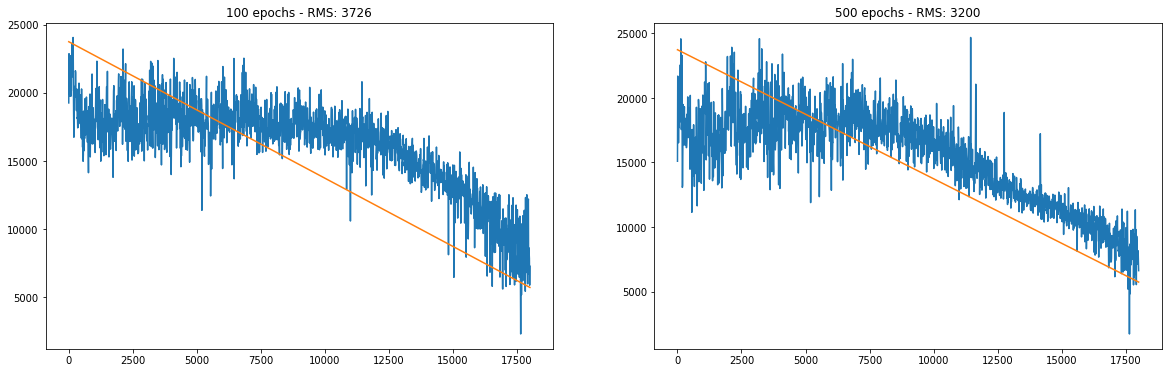

In [197]:
evaluate_signal(signal_1_3_hor, 5730)

1139/1139 [==============================] - 1s 952us/step


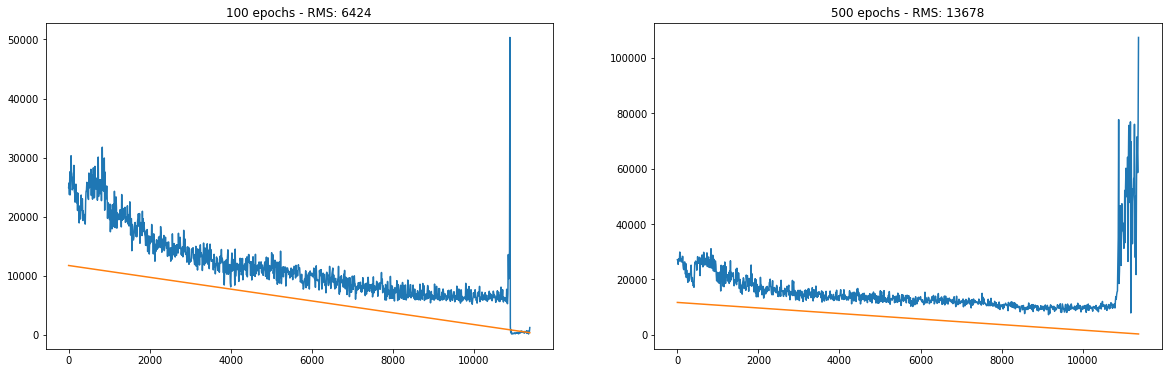

In [198]:
%store -r signal_1_4_hor
evaluate_signal(signal_1_4_hor, 339)

2302/2302 [==============================] - 1s 557us/step


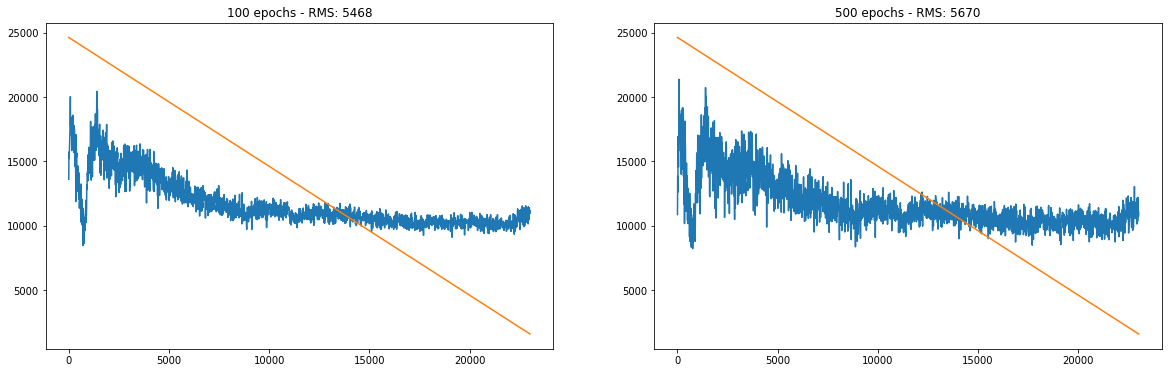

In [199]:
%store -r signal_1_5_hor
evaluate_signal(signal_1_5_hor, 1610)

2302/2302 [==============================] - 1s 544us/step


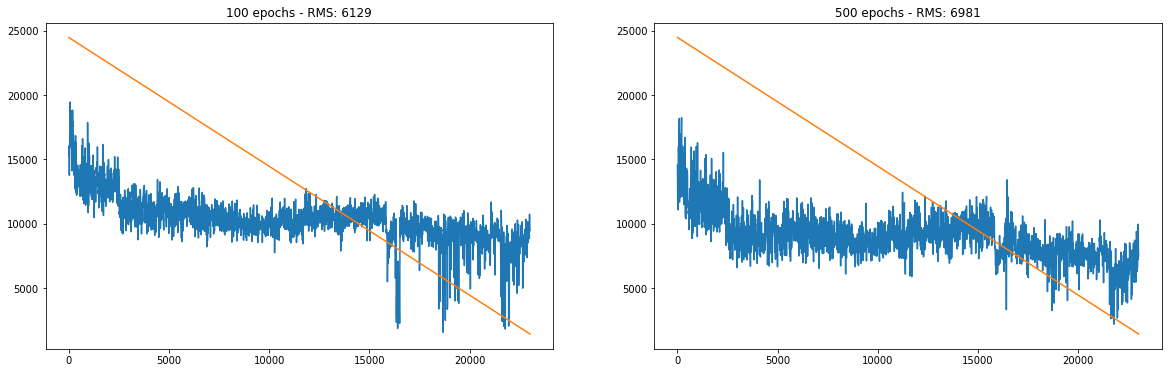

In [200]:
%store -r signal_1_6_hor
evaluate_signal(signal_1_6_hor, 1460)

1502/1502 [==============================] - 1s 829us/step


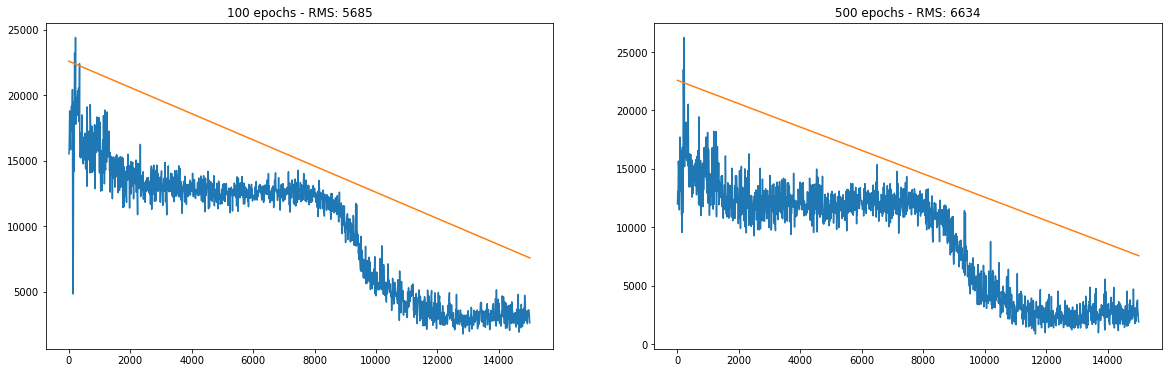

In [201]:
%store -r signal_1_7_hor
evaluate_signal(signal_1_7_hor, 7570)